## Explore the impact of the number of steps per period on learning

In [27]:
%load_ext autoreload
%autoreload 2

# import libraries
import torch.nn as nn
import torch
import numpy as np
from forage_training import train_multiple_networks
from forage_analysis import get_mean_perf_by_seq_len
import ngym_foraging as ngym_f
from ngym_foraging.wrappers import pass_reward, pass_action
import gym
import os
import pandas as pd

# GLOBAL VARIABLES
# check if GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# name of the task on the neurogym library
TASK = 'ForagingBlocks-v0'

TRAINING_KWARGS = {'dt': 100,
                   'lr': 1e-2,
                   'batch_size': 16,
                   'seq_len': 300,
                   'TASK': TASK}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# define parameters configuration
env_seed = 123
total_num_timesteps = 600000
num_periods = total_num_timesteps // 300
TRAINING_KWARGS['num_periods'] = num_periods
# create folder to save data based on env seed
# main_folder = 'C:/Users/saraf/OneDrive/Documentos/IDIBAPS/foraging RNNs/nets/'
main_folder = '/home/molano/Dropbox/Molabo/foragingRNNs/' # '/home/molano/foragingRNNs_data/nets/'
test_flag = ''
filename = 'training_nets'+test_flag+'.csv'
# Set up the task
w_factor = 0.00001
mean_ITI = 200
max_ITI = 400
fix_dur = 100
dec_dur = 100
blk_dur = 50
probs = np.array([0.1, 0.9])
env_kwargs = {'dt': TRAINING_KWARGS['dt'], 'probs': probs,
              'blk_dur': blk_dur, 'timing':
                  {'ITI': ngym_f.random.TruncExp(mean_ITI, 100, max_ITI),
                    # mean, min, max
                    'fixation': fix_dur, 'decision': dec_dur},
                  # Decision period}
                  'rewards': {'abort': 0., 'fixation': 0., 'correct': 1.}}
TRAINING_KWARGS['classes_weights'] =\
    torch.tensor([w_factor*TRAINING_KWARGS['dt']/(mean_ITI),
                  w_factor*TRAINING_KWARGS['dt']/fix_dur, 2, 2])
# call function to sample
env = gym.make(TASK, **env_kwargs)
env = pass_reward.PassReward(env)
env = pass_action.PassAction(env)
# set seed
env.seed(env_seed)
env.reset()
net_kwargs = {'hidden_size': 128,
              'action_size': env.action_space.n,
              'input_size': env.observation_space.shape[0]}
TRAINING_KWARGS['env_kwargs'] = env_kwargs
TRAINING_KWARGS['net_kwargs'] = net_kwargs

# create folder to save data based on parameters
save_folder = (f"{main_folder}w{w_factor}_mITI{mean_ITI}_xITI{max_ITI}_f{fix_dur}_"
                f"d{dec_dur}_nb{np.round(blk_dur/1e3, 1)}_"
                f"prb{probs[0]}")

# Save config as npz
np.savez(save_folder+'/config.npz', **TRAINING_KWARGS)

num_steps_plot = 100
num_steps_test = 1000
debug = False
num_networks = 4
criterion = nn.CrossEntropyLoss(weight=TRAINING_KWARGS['classes_weights'])

In [29]:
print(save_folder)

/home/molano/Dropbox/Molabo/foragingRNNs/w1e-05_mITI200_xITI400_f100_d100_nb0.0_prb0.1


No handles with labels found to put in legend.


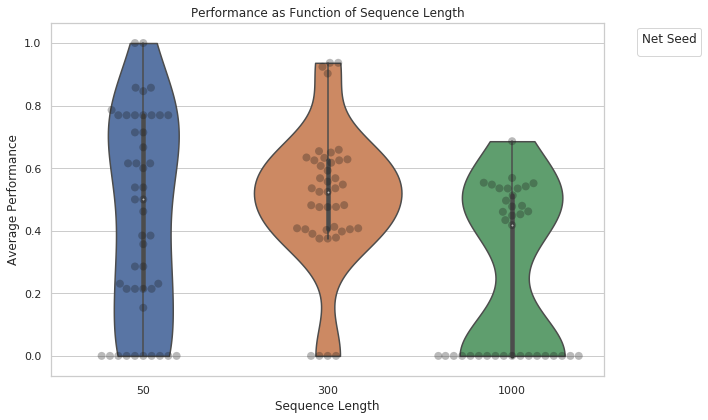

In [30]:
train = True
# define parameter to explore
seq_len_mat = np.array([50, 300, 1000])


if train:
  for seq_len in seq_len_mat:
    num_periods = total_num_timesteps // seq_len
    _, _ = train_multiple_networks(mean_ITI=mean_ITI, fix_dur=fix_dur, blk_dur=blk_dur,
                              num_networks=num_networks, env=env,
                              env_seed=env_seed, main_folder=main_folder, save_folder=save_folder,
                              filename=filename, env_kwargs=env_kwargs, net_kwargs=net_kwargs,
                              criterion=criterion, num_periods=num_periods, seq_len=seq_len)

mperf_lists = get_mean_perf_by_seq_len(main_folder, filename, seq_len_mat, w_factor, mean_ITI, max_ITI, fix_dur, dec_dur, blk_dur, probs)
